The following cell needs to be run only once to install the packages that may not be available

In [2]:
%%capture 
!pip install nltk
!pip install gensim
!pip install itertools
!pip install spacy
!pip install langdetect
!pip install pprint
!pip install pyLDAvis

In [3]:
import os
import re
import pandas as pd
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from collections import defaultdict
import itertools
from gensim.models.tfidfmodel import TfidfModel
import spacy
from langdetect import detect, DetectorFactory
from gensim.models import CoherenceModel
from string import punctuation
from pprint import pprint
import gensim.models
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline


/home/yekta/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# only run once 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')  # Optional for better language support
nltk.download('averaged_perceptron_tagger')  # For POS tagging
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /home/yekta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yekta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yekta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yekta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/yekta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yekta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/yekta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       d

True

# CLEANING AND PRE-PROCESSING DATA 

The following procedures are implemented for Data Cleaning: 

1. Only keep English reviews (remove non-English) --- Task: check before and after number of rows (to see how many got deleted)
2. Turn everything into lower case 
3. Remove stopwords + additional stopwords such as "from" "subject" "reply" "app" "bank" "banking" + names of the banks "CIBC", "TD", "BMO", "RBC", "SCOTIA"
4. Remove punctuation 
5. Lemming/Stemming  

Throughtout this process, several **Variations** of the data are kept: 
1. `reviews` is a list of the original data frame's reviews column where each user review is an entry in the list
2. `reviews_corpus` is a block of text where all reviews are joined together, and everything is lower cased  
3. `tokenized_doc_to_sentences` is the sentence tokenized version of `reviews_corpus`, a list of strings 
4. `tokenized_doc_to_words` is the word tokenized version of `tokenized_doc_to_sentences`, a list of lists where each outer list a review, then the inner lists each correspond to the sentences within the review 

The data cleaning is performed on all variations of the data. Therefore, each 4 types of data that are kept have clean and raw versions. Both types are saved to disk for easier upload later. 

# IMPORTANT FUNCTIONS 

Below are descriptions of functions. At various points, we have employed the help of ChatGPT4 (chat.openai.com). Please look out for the comment indicating start and end of code provided or fixed by AI. 

1. `is_english` detects non-English and English texts. We use this function for data cleaning, as several of the reviews are in languages other than English. 
2. `remove_punc` removes punctuation specifically declared as a regular expression in `punctuation_to_remove` 
3. `generate_dictionary` creates a gensim dictionary and corpus, and saves the dictionary to a matrix model format for easier retrival 
4. `print_top_10_words` prints the top 10 words in a corpus using TF-IDF (weighted)
5. `build_lda_model` builds our topic modeling model based on LDA, allowing for several models with different parameters to be trained for comparison to pick the best model parameters (parameter tuning)
6. `train_models` trains the LDA models and returns a list with all the models 
7. `calculate_preplexity` calculates model perplexity 
8. `calculate_coherence` calculates model coherence 
9. `print_topics` prints the topic modeling results with word weights 
10. `remove_stopwords_from_sentence` removes stopwords from sentences while keeping the sentence structure   
11. `build_model_comparison_table` trains several models, and saves the results of perplexity and coherence in one dataframe for easy comparison 
12. `find_best_model` loops through the dataframe of all models trained and finds minimum perplexity and maximum coherence 
13. `pick_best_model` returns the model parameters that give the best combination perplexity and coherence scores 


In [5]:
# ---------------------- START OF CHATGPT CODE
# PROMPT was: finish this function: def save_file(name, extension, content):
def save_file(name, extension, content):
    """
    Save a file with the specified name, extension, and content.

    Args:
    name (str): The name of the file (without extension).
    extension (str): The file extension (e.g., 'txt', 'csv').
    content (str): The content to be saved in the file.

    Returns:
    None
    """
    # Combine name and extension to form the full file name
    filename = f"{name}.{extension}"

    # Check if the file already exists
    if os.path.exists(filename):
        print(f"The file {filename} already exists. Overwriting...")
    
    # Open the file and write the content
    try:
        with open(filename, 'w') as file:
            file.write(content)
        print(f"File {filename} saved successfully.")
    except Exception as e:
        print(f"Error while saving file: {e}")
# ---------------------- END OF CHATGPT CODE 



## DATASET 

In [6]:
df = pd.read_csv("top5banksReviews_v1.csv")
df.head()

,rating,title,review,Bank
0,4,Could Use Improvements,"If there is only one possible account, I shoul...",BMO
1,4,Verify,Suddenly I am being asked to verify this devic...,BMO
2,1,Works terrible on my new phone,"On my new phone, practically every time I open...",BMO
3,1,Bare bones app,No features to make this app stand out amongst...,BMO
4,1,Not working with iOS12.2,This app won’t work with iOS12.2. Every time I...,BMO


In [7]:
df_copy = df.copy() # keeping a copy of the original data 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11980 entries, 0 to 11979
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  11980 non-null  int64 
 1   title   11979 non-null  object
 2   review  11980 non-null  object
 3   Bank    11980 non-null  object
dtypes: int64(1), object(3)
memory usage: 374.5+ KB


In [9]:
# ---------------------- START OF CHATGPT CODE
def is_english(text):
    DetectorFactory.seed = 0
    """input needs to be string"""
    try:
        return detect(text) == 'en'
    except:
        return False  
    
df['is_english'] = df['review'].apply(is_english)

# ---------------------- END OF CHATGPT CODE 

df = df[df['is_english']].drop(columns=['is_english']) 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11115 entries, 0 to 11979
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  11115 non-null  int64 
 1   title   11114 non-null  object
 2   review  11115 non-null  object
 3   Bank    11115 non-null  object
dtypes: int64(1), object(3)
memory usage: 434.2+ KB


### DATA VERSIONS - BEFORE CLEANING 

In [11]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'reply', 'banking', 'bank', 'app', 'apps', 'banks', 'cibc', 'rbc', 'td', 'scotia', 'bmo'])

In [12]:
reviews = list(df['review']) 
#reviews[:3]

reviews_corpus = " ".join([str(review) for review in reviews])
#reviews_corpus[:3]

tokenized_doc_to_sentences = sent_tokenize(reviews_corpus)
#tokenized_doc_to_sentences[:3]

tokenized_doc_to_words = [word_tokenize(sent) for sent in tokenized_doc_to_sentences]
# tokenized_doc_to_words[:3]


In [14]:
# SAVE DATA TO FILES 
save_file('reviews', 'txt', str(reviews))
save_file('reviews_corpus', 'txt', reviews_corpus)
save_file('tokenized_doc_to_sentences', 'txt', str(tokenized_doc_to_sentences))
save_file('tokenized_doc_to_words', 'txt', str(tokenized_doc_to_words))

File reviews.txt saved successfully.
File reviews_corpus.txt saved successfully.
File tokenized_doc_to_sentences.txt saved successfully.
File tokenized_doc_to_words.txt saved successfully.


### DATA CLEANING FUNCTIONS 

In [232]:
def remove_punc(text):
#     """Takes in some text, removes specific punctuations from them"""
#     punctuation_to_remove = r"[\[\]\(\)!?‘’'\'\"\.,;:]"
#     # punctuation_to_remove = r"[\[\]\(\)!?\"\.,;:]"
#     no_punc = re.sub(punctuation_to_remove, "", text)
#     no_punc_words = [word for word in text if word not in punctuation]
#     no_punc = ''.join(no_punc_words)
    
#     return no_punc
    punctuation_to_remove = r"[\[\]\(\)!?‘’'\".,;:]"
    no_punc = re.sub(punctuation_to_remove, "", text)
    return no_punc

stemmer = PorterStemmer()


def remove_stopwords_from_sentence(sentence):

    filtered_words = [word for word in sentence.split() if word.lower() not in stop_words]
    
    filtered_sentence = ' '.join(filtered_words)

    return filtered_sentence

### DATA VERSIONS - AFTER CLEANING 

In [233]:
# LOWER CASE
reviews_corpus_lc = list(df['review'])
reviews_corpus_lc = [review.lower() for review in reviews_corpus_lc]

# NOTE: this is each review tokenized sentence by sentence, so it's a list of lists 
tokenized_doc_to_sentences_lc_review_Sentenced = [sent_tokenize(review) for review in reviews_corpus_lc] 

# NOTE: this is the entire review column tokenized by sentences, then tokenized by words 
tokenized_doc_to_sentences_lc = sent_tokenize(' '.join(reviews_corpus_lc))
tokenized_doc_to_words_lc = [word_tokenize(sent) for sent in tokenized_doc_to_sentences_lc]



In [234]:
reviews_corpus_lc[:3]

['if there is only one possible account, i should not have to select it each time i need to deposit a cheque. if there are multiple accounts, it would be good if it allowed you to choose a default account to deposit to. other bank apps are set up this way.',
 'suddenly i am being asked to verify this device almost every time i try to log in. yes i enable ‘trust this device’ every time. what’s up with this??',
 'on my new phone, practically every time i open the app it asks to verify if it’s me and sends me a text. it then asks if i’d like to stay logged in on this phone in the future so it can just use face id and avoid the text (i check off the box to confirm this) but it doesn’t matter, it almost always sends me the text anyways.\n\nother times it will let me just use face id to get in as it should but then when i tap on any of my accounts it just gets stuck as if it’s loading all my transactions but they never come up. i have to manually force close the app and go back in, usually h

In [235]:
tokenized_doc_to_sentences_lc[:3]

['if there is only one possible account, i should not have to select it each time i need to deposit a cheque.',
 'if there are multiple accounts, it would be good if it allowed you to choose a default account to deposit to.',
 'other bank apps are set up this way.']

In [236]:
tokenized_doc_to_words_lc[:1]

[['if',
  'there',
  'is',
  'only',
  'one',
  'possible',
  'account',
  ',',
  'i',
  'should',
  'not',
  'have',
  'to',
  'select',
  'it',
  'each',
  'time',
  'i',
  'need',
  'to',
  'deposit',
  'a',
  'cheque',
  '.']]

In [237]:
# REMOVE STOPWORDS 
reviews_corpus_stpw = list(df['review'].apply(remove_stopwords_from_sentence))
tokenized_doc_to_sentences_stpw = sent_tokenize(' '.join(reviews_corpus_stpw))
tokenized_doc_to_words_stpw = [word_tokenize(sent) for sent in tokenized_doc_to_sentences_stpw]







In [238]:
reviews_corpus_stpw[:3]

['one possible account, select time need deposit cheque. multiple accounts, would good allowed choose default account deposit to. set way.',
 'Suddenly asked verify device almost every time try log in. Yes enable ‘trust device’ every time. What’s this??',
 'new phone, practically every time open asks verify it’s sends text. asks I’d like stay logged phone future use Face ID avoid text (I check box confirm this) doesn’t matter, almost always sends text anyways. times let use Face ID get tap accounts gets stuck it’s loading transactions never come up. manually force close go back in, usually 2 step verification process again. old iPhone, perfect. never either issues, anyone issues???']

In [239]:
tokenized_doc_to_sentences_stpw[:3]

['one possible account, select time need deposit cheque.',
 'multiple accounts, would good allowed choose default account deposit to.',
 'set way.']

In [240]:
tokenized_doc_to_words_stpw[:1]

[['one',
  'possible',
  'account',
  ',',
  'select',
  'time',
  'need',
  'deposit',
  'cheque',
  '.']]

In [241]:
# REMOVE PUNCTUATION 
reviews_corpus_noPnc = [remove_punc(review) for review in reviews_corpus_stpw] 
tokenized_doc_to_sentences_noPnc = [remove_punc(sentence) for sentence in tokenized_doc_to_sentences_stpw]
tokenized_doc_to_words_noPnc = [word_tokenize(sent) for sent in tokenized_doc_to_sentences_noPnc]


In [242]:
reviews_corpus_noPnc[:3]

['one possible account select time need deposit cheque multiple accounts would good allowed choose default account deposit to set way',
 'Suddenly asked verify device almost every time try log in Yes enable trust device every time Whats this',
 'new phone practically every time open asks verify its sends text asks Id like stay logged phone future use Face ID avoid text I check box confirm this doesnt matter almost always sends text anyways times let use Face ID get tap accounts gets stuck its loading transactions never come up manually force close go back in usually 2 step verification process again old iPhone perfect never either issues anyone issues']

In [243]:
tokenized_doc_to_sentences_noPnc[:3]

['one possible account select time need deposit cheque',
 'multiple accounts would good allowed choose default account deposit to',
 'set way']

In [244]:
tokenized_doc_to_words_noPnc[:1]

[['one', 'possible', 'account', 'select', 'time', 'need', 'deposit', 'cheque']]

In [245]:
stemmed_data = [[stemmer.stem(word) for word in sentence] for sentence in tokenized_doc_to_words_noPnc]
stemmed_data[:3]

[['one', 'possibl', 'account', 'select', 'time', 'need', 'deposit', 'chequ'],
 ['multipl',
  'account',
  'would',
  'good',
  'allow',
  'choos',
  'default',
  'account',
  'deposit',
  'to'],
 ['set', 'way']]

In [246]:
# SAVE TO FILES 
save_file('reviews_corpusCLN', 'txt', str(reviews_corpus_noPnc))
save_file('tokenized_doc_to_sentencesCLN', 'txt', str(tokenized_doc_to_sentences_noPnc))
save_file('tokenized_doc_to_wordsCLN', 'txt', str(tokenized_doc_to_words_noPnc))

The file reviews_corpusCLN.txt already exists. Overwriting...
File reviews_corpusCLN.txt saved successfully.
The file tokenized_doc_to_sentencesCLN.txt already exists. Overwriting...
File tokenized_doc_to_sentencesCLN.txt saved successfully.
The file tokenized_doc_to_wordsCLN.txt already exists. Overwriting...
File tokenized_doc_to_wordsCLN.txt saved successfully.


### ANALYSIS FUNCTIONS 

In [175]:
def print_top_words(corpus_, dictionary_):
    total_word_count = defaultdict(int)
    word_weights = defaultdict(float)

    for word_id, word_count in itertools.chain.from_iterable(corpus_):
        total_word_count[word_id] += word_count
        
    sorted_tota_words_count = sorted(total_word_count.items(), key = lambda w: w[1], reverse = True)
    
    tfidf = TfidfModel(corpus_)


# ---------------------- START OF CHATGPT CODE
    for doc in corpus_:
        tfidf_weights = tfidf[doc]  # Calculate TF-IDF for the review
    
    for term_id, weight in tfidf_weights:
        word_weights[term_id] += weight  # Aggregate the weight for the term

    # Sort the terms by weight in descending order
    sorted_word_weights = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)

    # Print the top 10 terms with their weights
    top_words = [(dictionary_.get(term_id), weight) for term_id, weight in sorted_word_weights[:50]]

    for word, weight in top_words:
        print(word, weight)

# ---------------------- END OF CHATGPT CODE 


In [176]:
def generate_dictionary(text, name):
    """ 
    As input takes in the text to build the dictionary for and the name of a .mm file
    """ 
    
    dictionary = Dictionary(text)
    
    corpus = [dictionary.doc2bow(review) for review in text] 
    
    filename = f"{name}.mm"
    
    MmCorpus.serialize(filename, corpus)
    
    return dictionary, corpus


def build_lda_model(n_topic, corpus_, dictionary_):
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus_,
                                              num_topics = n_topic,
                                              id2word = dictionary_,
                                              random_state = 100,
                                              update_every = 1,
                                              chunksize = 1000,
                                              passes = 10,
                                              alpha = 'auto',
                                              per_word_topics = True)
    return lda_model


def train_models(corpus_, dictionary_):
    list_to_hold_models = []
    topic_n_to_try = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
    for i in range(len(topic_n_to_try)):
        list_to_hold_models.insert(i, build_lda_model(topic_n_to_try[i], corpus_, dictionary_))
        
    return list_to_hold_models


def calculate_perplexity(model, corpus_):
    perplexity = model.log_perplexity(corpus_)
    return perplexity

def calculate_coherence(model, text, dictionary_):
    coherence_model_lda = CoherenceModel(model = model, texts = text, dictionary = dictionary_, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    return coherence_lda

def build_model_comparison_table(list_of_models, corpus_, dictionary_, data):
    tracker = 5 
    models_perplexity = []
    models_coherence = []
    models_topics = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
    
    for model in list_of_models:
        models_perplexity.append(calculate_perplexity(model, corpus_))
        models_coherence.append(calculate_coherence(model, data, dictionary_))
        tracker += 1
        
    if tracker == 15:
        print("Successfully generated model comparison table.") 
        
    models_df = pd.DataFrame({
        'Num_Topics': models_topics,
        'Coherence': models_coherence,
        'Perplexity': models_perplexity,
    })

    return models_df


def find_best_model(models_df):
    print("Number of topics with the maximum Coherence is ", models_df.loc[models_df['Coherence'].idxmax(), 'Num_Topics'])
    print("Number of topics with the minimum Perplexity is ", models_df.loc[models_df['Perplexity'].idxmin(), 'Num_Topics'])
    
    if models_df.loc[models_df['Coherence'].idxmax(), 'Num_Topics'] == models_df.loc[models_df['Perplexity'].idxmin(), 'Num_Topics']:
        best_model_row = models_df.loc[models_df['Perplexity'].idxmin()]
        best_number_of_topics = best_model_row['Num_Topics']
    else:
        models_df['Normalized_Perplexity'] = (models_df['Perplexity'] - models_df['Perplexity'].min()) / (models_df['Perplexity'].max() - models_df['Perplexity'].min())
        models_df['Normalized_Coherence'] = (models_df['Coherence'] - models_df['Coherence'].min()) / (models_df['Coherence'].max() - models_df['Coherence'].min())

        models_df['Inverted_Perplexity'] = 1 - models_df['Normalized_Perplexity'] # because smaller is better

        weight_preplexity = 0.5
        weight_coherence = 0.5

        models_df['Score'] = weight_coherence * models_df['Normalized_Coherence'] + weight_preplexity * models_df['Inverted_Perplexity']

        best_model_row = models_df.loc[models_df['Score'].idxmax()]
        best_number_of_topics = best_model_row['Num_Topics']

    print(best_model_row)
                                       
    return best_model_row, best_number_of_topics
                                                                                                     
                                                                                                
def pick_best_model(num, m):
    """ 
    Model inputs are: 
        num = best number of topics found according to find_best_model()
        m = list of models 
    """
    model_index = num - 5 
    model_index = int(model_index)
                                       
    best_model = m[model_index]
                                       
    return best_model  
                                                                  
def print_topics(model, corpus):
    pprint(model.print_topics())
    doc_lda = model[corpus]
    
    return doc_lda

In [247]:
#tokens = tokenized_doc_to_words_noPnc
tokens = stemmed_data

bigrams = [list(ngrams(sentence, 2)) for sentence in tokens]  # Bigrams
trigrams = [list(ngrams(sentence, 3)) for sentence in tokens]  # Trigrams

bigrams_combined = [[f"{a} {b}" for a, b in sublist] for sublist in bigrams]
trigrams_combined = [[f"{a} {b} {c}" for a, b, c in sublist] for sublist in trigrams]


#### Generate Dictionary and Corpuses for unigrams, bigrams and trigrams 

In [248]:
unigram_dict = generate_dictionary(tokens, 'mmcorpus_ios_unigrams')[0]
unigram_corpus = generate_dictionary(tokens, 'mmcorpus_ios_unigrams')[1]




In [249]:
bigram_dict = generate_dictionary(bigrams_combined, 'mmcorpus_ios_bigrams')[0]
bigram_corpus = generate_dictionary(bigrams_combined, 'mmcorpus_ios_bigrams')[1]

In [250]:

trigram_dict = generate_dictionary(trigrams_combined, 'mmcorpus_ios_trigrams')[0]
trigram_corpus = generate_dictionary(trigrams_combined, 'mmcorpus_ios_trigrams')[1]

Top Words 

In [251]:
print_top_words(unigram_corpus, unigram_dict)

simpl 0.8269718651719848
easi 0.5622433051748758


In [252]:
print_top_words(bigram_corpus, bigram_dict)

easi simpl 1.0


In [253]:
print_top_words(trigram_corpus, trigram_dict)

In [254]:
# uni_gram_models = []

uni_gram_models = train_models(unigram_corpus, unigram_dict)

In [255]:
unigram_model_comparison = build_model_comparison_table(uni_gram_models, unigram_corpus, unigram_dict, tokens)
unigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.503522,-7.031902
1,6,0.474547,-7.058759
2,7,0.484822,-7.090710
3,8,0.439361,-7.134292
4,9,0.473287,-7.202629
5,10,0.402439,-7.304552
6,11,0.420414,-7.462256
7,12,0.422297,-7.712037
8,13,0.363059,-8.081400
9,14,0.370676,-8.439311


In [256]:
unigram_best_row = find_best_model(unigram_model_comparison)[0]
unigram_best_n_topics = find_best_model(unigram_model_comparison)[1]

Number of topics with the maximum Coherence is  5
Number of topics with the minimum Perplexity is  15
Num_Topics               14.000000
Coherence                 0.370676
Perplexity               -8.439311
Normalized_Perplexity     0.137377
Normalized_Coherence      0.143672
Inverted_Perplexity       0.862623
Score                     0.503148
Name: 9, dtype: float64
Number of topics with the maximum Coherence is  5
Number of topics with the minimum Perplexity is  15
Num_Topics               14.000000
Coherence                 0.370676
Perplexity               -8.439311
Normalized_Perplexity     0.137377
Normalized_Coherence      0.143672
Inverted_Perplexity       0.862623
Score                     0.503148
Name: 9, dtype: float64


In [257]:
unigram_best_model = pick_best_model(unigram_best_n_topics, uni_gram_models)

In [258]:
print("Best Unigram model is:", unigram_best_model)

Best Unigram model is: LdaModel<num_terms=8252, num_topics=14, decay=0.5, chunksize=1000>


In [259]:
# bi_gram_models = []

bi_gram_models = train_models(bigram_corpus, bigram_dict)

In [260]:
bigram_model_comparison = build_model_comparison_table(bi_gram_models, bigram_corpus, bigram_dict, bigrams_combined)
bigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.521974,-12.583105
1,6,0.561168,-12.965582
2,7,0.564346,-13.511497
3,8,0.583183,-14.280479
4,9,0.567839,-15.391978
5,10,0.573179,-16.692533
6,11,0.585259,-18.312785
7,12,0.597543,-19.743084
8,13,0.594931,-21.153182
9,14,0.600651,-22.690274


In [261]:
bigram_best_row = find_best_model(bigram_model_comparison)[0]
bigram_best_n_topics = find_best_model(bigram_model_comparison)[1]

Number of topics with the maximum Coherence is  15
Number of topics with the minimum Perplexity is  15
Num_Topics    15.000000
Coherence      0.601045
Perplexity   -23.530992
Name: 10, dtype: float64
Number of topics with the maximum Coherence is  15
Number of topics with the minimum Perplexity is  15
Num_Topics    15.000000
Coherence      0.601045
Perplexity   -23.530992
Name: 10, dtype: float64


In [262]:
bigram_best_model = pick_best_model(bigram_best_n_topics, bi_gram_models)


In [263]:
print("Best Bigram model is:", bigram_best_model)

Best Bigram model is: LdaModel<num_terms=98170, num_topics=15, decay=0.5, chunksize=1000>


In [264]:
# tri_gram_models = []

tri_gram_models = train_models(trigram_corpus, trigram_dict)

In [265]:
trigram_model_comparison = build_model_comparison_table(tri_gram_models, trigram_corpus, trigram_dict, trigrams_combined)
trigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.679163,-13.632014
1,6,0.690540,-18.637951
2,7,0.668556,-20.056700
3,8,0.648240,-17.091047
4,9,0.611342,-20.387500
5,10,0.546128,-25.193121
6,11,0.558331,-27.717307
7,12,0.539569,-29.870828
8,13,0.491785,-31.834333
9,14,0.493631,-33.318609


In [266]:
trigram_best_row = find_best_model(trigram_model_comparison)[0]
trigram_best_n_topics = find_best_model(trigram_model_comparison)[1]

Number of topics with the maximum Coherence is  6
Number of topics with the minimum Perplexity is  15
Num_Topics                6.000000
Coherence                 0.690540
Perplexity              -18.637951
Normalized_Perplexity     0.765068
Normalized_Coherence      1.000000
Inverted_Perplexity       0.234932
Score                     0.617466
Name: 1, dtype: float64
Number of topics with the maximum Coherence is  6
Number of topics with the minimum Perplexity is  15
Num_Topics                6.000000
Coherence                 0.690540
Perplexity              -18.637951
Normalized_Perplexity     0.765068
Normalized_Coherence      1.000000
Inverted_Perplexity       0.234932
Score                     0.617466
Name: 1, dtype: float64


In [267]:
trigram_best_model = pick_best_model(trigram_best_n_topics, tri_gram_models)

In [268]:
print("Best Trigram model is:", trigram_best_model)

Best Trigram model is: LdaModel<num_terms=139128, num_topics=6, decay=0.5, chunksize=1000>


|N-gram|Perplexity|Coherence|# of topics|
|------|----------|---------|-----------|
|Uni| - 8.391336 |0.388072 |15|
|Bi| -21.654707| 0.598744 |15|
|Tri|-26.147505|0.610071|15|
|------|----------|---------|-----------|
|Uni|-8.360322|0.421913|15|
|Bi|-21.532140|0.586661|15|
|Tri|-24.969967|0.592315|15|
|------|----------|---------|-----------|
|Uni|  -8.439311 |0.370676 |14|
|Bi|-23.530992|0.601045|15|
|Tri|-18.637951|0.690540|6|


Scoring the Bigram and Trigram best models: 
- $$score = (1 + 23.53) \times 0.5 + 0.5 \times 0.601 = 12.5655$$
- $$score = (1 + 18.638) \times 0.5 + 0.5 \times 0.691 = 10.1645$$

Therefore decided to use `bigram_best_model` as the best model.
 

In [271]:
best_topic_model = bigram_best_model

In [272]:
print_topics(best_topic_model, trigram_corpus)

[(0,
  '0.011*"dont know" + 0.009*"account balanc" + 0.008*"user experi" + '
  '0.007*"home screen" + 0.006*"thank much" + 0.006*"enter password" + '
  '0.006*"updat phone" + 0.006*"time use" + 0.005*"see balanc" + 0.004*"doesnt '
  'allow"'),
 (1,
  '0.010*"uninstal reinstal" + 0.009*"get error" + 0.008*"never problem" + '
  '0.007*"dont want" + 0.006*"open account" + 0.006*"last month" + 0.004*"log '
  'back" + 0.004*"longer use" + 0.004*"need use" + 0.003*"click “"'),
 (2,
  '0.026*"face id" + 0.015*"sign in" + 0.014*"love app" + 0.012*"cant use" + '
  '0.011*"first time" + 0.009*"cant log" + 0.007*"log account" + 0.007*"cant '
  'see" + 0.007*"use work" + 0.006*"would great"'),
 (3,
  '0.029*"user friendli" + 0.009*"pleas tri" + 0.008*"tri get" + 0.008*"older '
  'version" + 0.006*"work anymor" + 0.006*"much better" + 0.005*"doesnt even" '
  '+ 0.004*"wait line" + 0.004*"dont use" + 0.003*"peopl use"'),
 (4,
  '0.052*"credit card" + 0.024*"doesnt work" + 0.014*"say “" + 0.013*"fix 

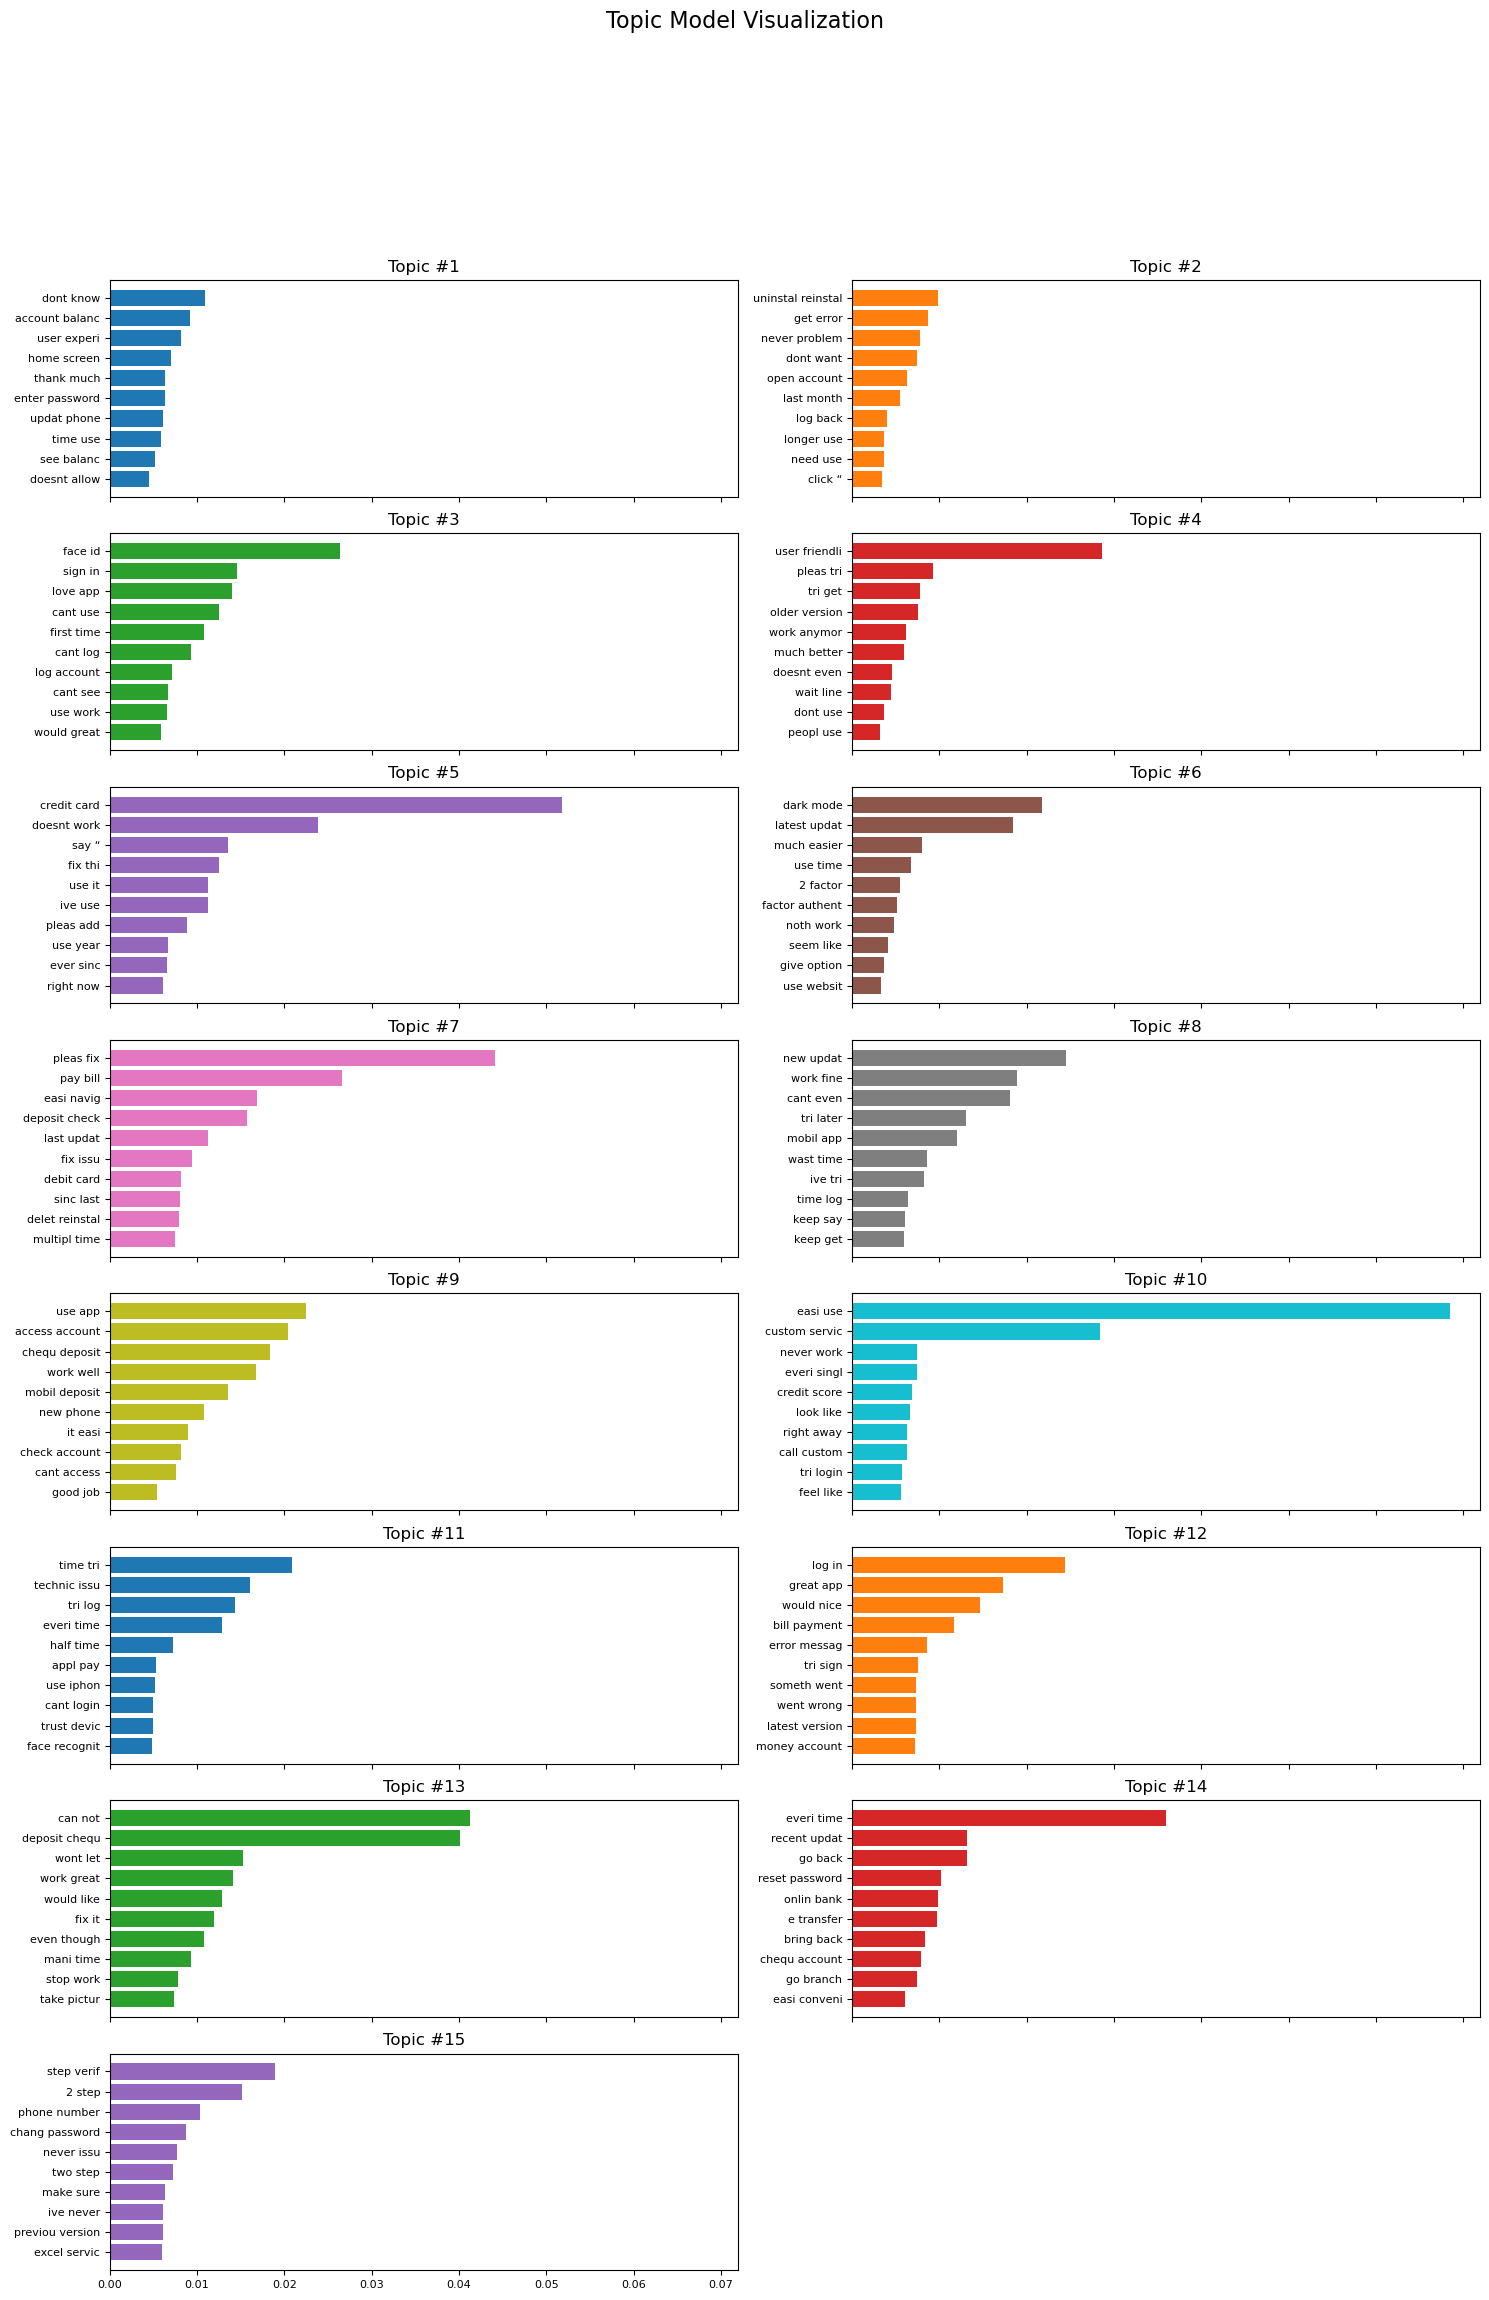

In [276]:
# Extract topics and their top terms
import numpy as np 

topics = best_topic_model.show_topics(num_topics = 15, num_words=10, formatted=False)

# Prepare data for plotting
data = []
for topic_id, terms in topics:
    words, weights = zip(*terms)  # Unzip words and weights
    data.append((topic_id, words, weights))

# Plotting
num_topics = len(data)
fig, axes = plt.subplots(nrows=(num_topics // 2) + (num_topics % 2), ncols=2, figsize=(15, num_topics * 1.5), sharex=True)
axes = axes.flatten()

for i, (topic_id, words, weights) in enumerate(data):
    ax = axes[i]
    y_pos = np.arange(len(words))
    ax.barh(y_pos, weights, align='center', color=f'C{i % 10}')  # Assign colors dynamically
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words, fontsize=10)
    ax.invert_yaxis()  # Top-down
    ax.set_title(f'Topic #{topic_id + 1}', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Topic Model Visualization", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9)
plt.savefig("ios_topicmodeling_whole.png")

plt.show()

In [280]:
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(best_topic_model, bigram_corpus, bigram_dict)
vis

/home/yekta/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/yekta/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/yekta/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/yekta/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/yekta/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires ver

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.141991 -0.016297       1        1  10.659054
6     -0.033500 -0.124956       2        1   8.815642
7     -0.017689  0.032719       3        1   8.756932
11    -0.015596  0.024042       4        1   7.867943
4     -0.014706  0.021234       5        1   7.838057
13    -0.011296  0.013080       6        1   7.454622
9     -0.014292  0.020022       7        1   7.289289
8     -0.007708  0.007288       8        1   5.911777
2     -0.005146  0.004272       9        1   5.740914
14    -0.006103  0.005319      10        1   5.676292
10    -0.006645  0.006882      11        1   5.422079
1     -0.002953  0.002143      12        1   5.211290
0     -0.002491  0.001736      13        1   4.919191
5     -0.002200  0.001484      14        1   4.444253
3     -0.001666  0.001033      15        1   3.992667, topic_info=               Term        Freq       Total Category  logprob  loglift
915        easi use  897.000000  897.000000  Default  30.0000  30.0000
256     credit card  730.000000  730.000000  Default  29.0000  29.0000
588         can not  789.000000  789.000000  Default  28.0000  28.0000
1     deposit chequ  769.000000  769.000000  Default  27.0000  27.0000
165       pleas fix  699.000000  699.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
356    develop team   11.091138   12.417223  Topic15  -6.4711   3.1078
2486   soon possibl   10.536985   11.863069  Topic15  -6.5223   3.1022
2870    balanc show   10.280979   11.607063  Topic15  -6.5469   3.0994
1158     updat look    9.846474   11.172559  Topic15  -6.5901   3.0944
3395     amount owe    9.835007   11.161092  Topic15  -6.5913   3.0942

[482 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3109     11  0.939863       $ $
1915      2  0.983267    % time
3355      7  0.975207       * *
2153      6  0.956555    1 star
3072     12  0.963540   10 year
...     ...       ...       ...
2142     15  0.918809  year now
2053      4  0.985540  “ someth
2311      5  0.977523      “ we
1986      7  0.940457  ” messag
1676      9  0.951405       ” “

[452 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 7, 8, 12, 5, 14, 10, 9, 3, 15, 11, 2, 1, 6, 4])

# SENTIMENT ANALYSIS

We use a train and test split, compare our sentiments using scipy classifiers, and use the ratings (above average + sigma as positive, below average - sigma as negative) to test how well our algorithm worked. 